## Within one cluster: structure prediction results and sequence similarity analysis

After submitting jobs on the HPC, ran once on litleo cluster, because accelgor and joltik were down, with newer versions of previously used modules:
- Python/3.11.3-GCCcore-12.3.0
- tqdm/4.66.1-GCCcore-12.3.0
- matplotlib/3.7.2-gfbf-2023a
- AlphaFold/2.3.2-foss-2023a

But relaxation failed, running on accelgor 

Relaxation now worked for all proteins


Can now move on to structure MSA and pLDDT evaluation, comparaison and annotation with foldseek

In [2]:
# imports
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Bio
import seaborn as sns
from Bio.PDB import *
from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import ClustalOmegaCommandline
import logomaker

### Zoom into results of structure prediction:

### Goal 1: extract MSA information from files

AlphaFold builds protein structure models based on information extracted from MSAs. Hence, the depth of the MSA is one of the metrics to take into account when looking at the overall quality of the protein prediction. 

To get this information, we will have to loop over the proteins, then go into the info file for each protein result, and extract this info from the line 'Sequence coverage'.

In [2]:
# extract the MSA depth from each log file
def extract_msa_depth(logfile):
    with open(logfile) as infile:
        # Read file and extract lines on MSA depth
        lines = infile.read().splitlines()
        start_i = None  # Initialize start index
        
        for i, line in enumerate(lines):
            if "Sequence coverage:" in line:
                start_i = i
                break  # Stop at the first occurrence
        
        # Ensure start_i was found before proceeding
        if start_i is None:
            print(f"Warning: 'Sequence coverage' not found in {logfile}")
            return None, None
        
        # Extract sequence coverage values
        msa_depth_text = lines[start_i]
        msa_depth_per_pos = []
        
        # Modify string to have space around square brackets for easier digit extraction
        msa_depth_text = msa_depth_text.replace("[", "[ ").replace("]", " ]")
        
        for word in msa_depth_text.split():
            if word.isdigit():
                msa_depth_per_pos.append(int(word))
        
        if not msa_depth_per_pos:
            print(f"Warning: No MSA depth values found in {logfile}")
            return None, None
        
        max_depth = max(msa_depth_per_pos)
        avg_depth = np.mean(msa_depth_per_pos)
        
        return max_depth, avg_depth

In [3]:
#store MSA info in dict
protein_msadepth = {}
path_results = os.path.join("results")

for protein in os.listdir(path_results):
    protein_dir = os.path.join(path_results, protein)
    logfile = os.path.join(protein_dir, f"{protein}_info.log")  

    # Ensure logfile exists before attempting to read it
    if os.path.isfile(logfile):
        max_depth, avg_depth = extract_msa_depth(logfile)
        if max_depth is not None and avg_depth is not None:
            protein_msadepth[protein] = (max_depth, avg_depth)
    else:
        print(f"Log file missing for {protein} in {batch}")

print(f"Finished MSA depth analysis.")


Finished MSA depth analysis.


### Goal 2: extract pLDDT information from files

AlphaFold builds protein structure models which it also gives a per-residue accuracy score, the pLDDT. This pLDDT can be used as a quality metric, hence, let's investigate the pLDDT scores for all our proteins.

To get this information, we will have to loop over the batches, then open the PDB file of the best/relaxed structure and extract the pLDDT scores.

In [4]:
# define a PDB parser
p = PDBParser()

In [5]:
# function for calculating average pLDDT
    # as copied and adapted from "paper_acetyltransferases" Notebook "Code_search_structure_annotation_Linux.ipynb" 
def avg_pLDDT(structure):
    for model in structure:
        for chain in model:
            count_residue = 0
            pLDDT_chain = 0
            for residue in chain:
                count_residue += 1
                count_atom = 0
                pLDDT_atom = 0
                for atom in residue:
                    count_atom += 1
                    pLDDT_atom += atom.get_bfactor()
                pLDDT_res = pLDDT_atom/count_atom
                # pLDDT_res = round(pLDDT_atom/count_atom,2)
                pLDDT_chain += pLDDT_res
        pLDDT_avg = round(pLDDT_chain/count_residue,2)
    return pLDDT_avg

In [6]:
protein_plddt = {}
path_results = os.path.join("results")

# Iterate over all protein folders in the results directory
for protein in os.listdir(path_results):
    protein_dir = os.path.join(path_results, protein)        
    # Extract pLDDT
    relaxed_pdb = os.path.join(protein_dir, f"{protein}_relaxed.pdb")
    structure = None

    if os.path.isfile(relaxed_pdb):
        structure = p.get_structure(protein, relaxed_pdb)
    else:
        for item in os.listdir(protein_dir):
            if "rank_1" in item and item.endswith(".pdb"):
                structure = p.get_structure(protein, os.path.join(protein_dir, item))
                break

    if structure:
        protein_plddt[protein] = avg_pLDDT(structure)
    else:
        print(f"No suitable PDB file found for {protein} in {batch}")

print(f"Finished pLDDT analysis.")

Finished pLDDT analysis.


### Goal 3: interpreting and plotting the pLDDTs and MSA depths

#### Plotting the pLDDTs and MSA depths

In [7]:
# the data for the MSA depth analysis
max_MSA_depth = [x[0] for x in protein_msadepth.values()]
avg_MSA_depth = [x[1] for x in protein_msadepth.values()]
data_MSAd = pd.DataFrame(data = {"protein" : protein_msadepth.keys(), "max MSA depth" : max_MSA_depth, "avg MSA depth" : avg_MSA_depth})

A common assessor for MSA depth is just the maximum depth over the entire protein. As a rule of thumb, a cut off of 30 sequences in the MSA is suggested for good quality predictions, so let's look how often we match this bar. 

In [9]:
avg_max = round(np.mean(max_MSA_depth))
med_max = np.median(max_MSA_depth)
min30_num = len(data_MSAd[data_MSAd["max MSA depth"] >= 30])
num_proteins = len(max_MSA_depth)
pct_ok = round(min30_num/num_proteins*100, 2)
print(f"On average, the maximal MSA depth used for structure prediction for our {num_proteins} proteins is {avg_max} sequences (median: {med_max}).")
print(f"The maximal MSA depth used for structure prediction for {min30_num} out of our {num_proteins} proteins ({pct_ok}%) is above 30 sequences, which is used as a general rule of thumb.")

On average, the maximal MSA depth used for structure prediction for our 10 proteins is 71 sequences (median: 69.5).
The maximal MSA depth used for structure prediction for 10 out of our 10 proteins (100.0%) is above 30 sequences, which is used as a general rule of thumb.


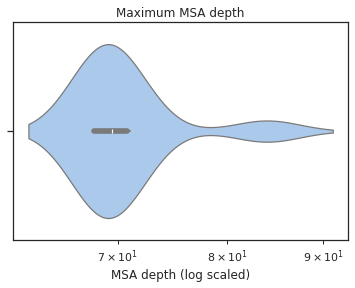

In [10]:
sns.set(style="ticks", palette="pastel")
maxF = sns.violinplot(x=data_MSAd["max MSA depth"], log_scale=True)
maxF.set(title = "Maximum MSA depth", xlabel = "MSA depth (log scaled)")
plt.show()

In [11]:
# however, averages can hide quite large discrepencies over entire proteins, so let's look at the average MSA depth as well
avg_avg = round(np.mean(avg_MSA_depth))
med_avg = round(np.median(avg_MSA_depth))
min30avg_num = len(data_MSAd[data_MSAd["avg MSA depth"] >= 30])
pct_ok_avg = round(min30avg_num/num_proteins*100, 2)
print(f"On average, the average MSA depth used for structure prediction for our {num_proteins} proteins is {avg_avg} sequences (median: {med_avg}).")
print(f"The average MSA depth used for structure prediction for {min30avg_num} out of our {num_proteins} proteins ({pct_ok_avg}%) is above 30 sequences, which is used as a general rule of thumb.")

On average, the average MSA depth used for structure prediction for our 10 proteins is 41 sequences (median: 38).
The average MSA depth used for structure prediction for 10 out of our 10 proteins (100.0%) is above 30 sequences, which is used as a general rule of thumb.


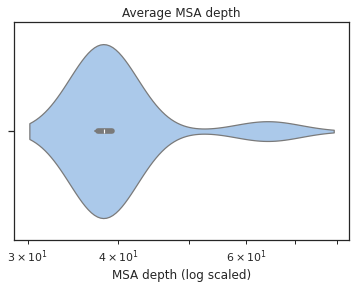

In [12]:
avgF = sns.violinplot(x=data_MSAd["avg MSA depth"], log_scale=True)
avgF.set(title = "Average MSA depth", xlabel = "MSA depth (log scaled)")
plt.show()

While the MSA depth is correlated to the quality, the actual quality metric for AlphaFold predictions lies in the pLDDT, so let's look at that. 

In [13]:
# the data for pLDDT analysis
data_plddt = pd.DataFrame(data = protein_plddt.items(), columns = ["protein", "avg pLDDT"])

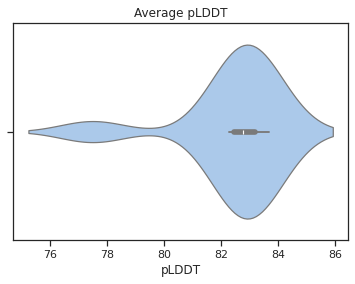

In [14]:
plddtF = sns.violinplot(x=data_plddt["avg pLDDT"])
plddtF.set(title = "Average pLDDT", xlabel = "pLDDT")
plt.show()

Let's investigate the correlation between those two: we expect there to be better pLDDT for proteins with deeper MSAs, and especially poor pLDDTs for proteins with shallow MSAs which have less than 30 sequences.

In [15]:
# creating combined dataframe
plddt_MSA_df = data_MSAd.merge(data_plddt)

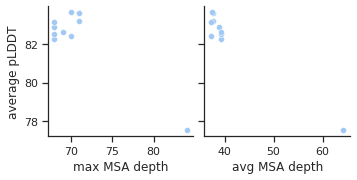

In [16]:
# plotting with pairplot
corrF = sns.pairplot(plddt_MSA_df, 
                 x_vars=["max MSA depth", "avg MSA depth"],
                 y_vars=["avg pLDDT"])
corrF.set(ylabel = "average pLDDT")
plt.show()

### Setting up for structure comparison Foldseek

In [3]:
#filtering foldseek results
# define a PDB parser
p = PDBParser()

In [4]:
# function for calculating average pLDDT of aligned region on FoldSeek results
def get_pLDDT(structure, start, stop):
    for model in structure:
        for chain in model:
            count_residue = 0
            pLDDT_chain = 0
            for residue in chain:
                if residue.id[1] in range(start,stop+1):
                    count_residue += 1
                    count_atom = 0
                    pLDDT_atom = 0
                    for atom in residue:
                        count_atom += 1
                        pLDDT_atom += atom.get_bfactor()
                    pLDDT_res = round(pLDDT_atom/count_atom,2)
                    pLDDT_chain += pLDDT_res
            pLDDT_range = round(pLDDT_chain/count_residue,2)
    return pLDDT_range 

In [ ]:
batch_dir = os.path.join("c_structure_annotation_clust","structure_comp_clust")
for filename in os.listdir(batch_dir):
    if filename.endswith("_relaxed.pdb"):  # Ensure processing only PDB files
        protein = filename.replace("_relaxed.pdb", "")  # Extract protein name

        # Load protein structure (since all are "relax")
        structure = p.get_structure(protein, os.path.join(batch_dir, "{0}_relaxed.pdb".format(protein)))

        # Process FoldSeek results for AF50m database
        data_af50m = pd.read_table(os.path.join(batch_dir, "{0}_relaxed_aln_af50m.txt".format(protein)), header=None, names=["query","target","fident","alnlen","mismatch","gapopen","qstart","qend","tstart","tend","evalue","bits","prob","lddt","lddtfull"])

    for i in range(0,len(data_af50m)):
        data_af50m.at[i,"pLDDT_qAln"] = get_pLDDT(structure, data_af50m.at[i,"qstart"],data_af50m.at[i,"qend"])

    data_af50m_filtered = data_af50m
    if len(data_af50m_filtered) != 0:
        data_af50m_filtered = data_af50m_filtered[(data_af50m_filtered["prob"] > 0.5) & (data_af50m_filtered["evalue"] < 1e-3) & (data_af50m_filtered["lddt"] >= 0.5) & (data_af50m_filtered["pLDDT_qAln"] >= 0.7)]
    data_af50m_filtered = data_af50m_filtered.reset_index()

    data_af50m_filtered.to_csv(os.path.join(batch_dir, f"{protein}_foldseek_af50m_filtered.csv"), index=False)     

        # Process FoldSeek results for PDB database

    data_pdb = pd.read_table(os.path.join(batch_dir, "{0}_relaxed_aln_pdb.txt".format(protein)), header=None, names=["query","target","fident","alnlen","mismatch","gapopen","qstart","qend","tstart","tend","evalue","bits","prob","lddt","lddtfull"])

    for i in range(0,len(data_pdb)):
        data_pdb.at[i,"pLDDT_qAln"] = get_pLDDT(structure, data_pdb.at[i,"qstart"],data_pdb.at[i,"qend"])

    data_pdb_filtered = data_pdb

    if len(data_pdb_filtered) != 0:
        data_pdb_filtered = data_pdb_filtered[(data_pdb_filtered["prob"] > 0.5) & (data_pdb_filtered["evalue"] < 1e-3) & (data_pdb_filtered["lddt"] >= 0.5) & (data_pdb_filtered["pLDDT_qAln"] >= 0.7)]
    data_pdb_filtered = data_pdb_filtered.reset_index()
            # store filtered FoldSeek results
    data_pdb_filtered.to_csv(os.path.join(batch_dir, f"{protein}_foldseek_pdb_filtered.csv"), index=False) 

### Sequence similarity analysis - Clustal O

In [5]:
#msa install.packages("BiocManager")
!conda install -c bioconda clustalo


/data/leuven/351/vsc35101/miniconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
/data/leuven/351/vsc35101/miniconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/

In [6]:
!pip install biopython logomaker matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 73.0 MB/s eta 0:00:00
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:


fasta_folder = "FASTA"
combined_fasta = "all_sequences.fasta"
aligned_output = "aligned.aln"

seq_records = []
for file in os.listdir(fasta_folder):
    if file.endswith(".fasta") or file.endswith(".fa"):
        path = os.path.join(fasta_folder, file)
        record = next(SeqIO.parse(path, "fasta"))  
        record.id = os.path.splitext(file)[0]
        record.description = ""
        seq_records.append(record)

# FASTA
SeqIO.write(seq_records, combined_fasta, "fasta")

# Run Clustal Omega for alignment
clustalomega_cline = ClustalOmegaCommandline(
    infile=combined_fasta,
    outfile=aligned_output,
    verbose=True,
    auto=True,
    outfmt="clu"
)
clustalomega_cline()

# Read aligned sequences
alignment = AlignIO.read(aligned_output, "clustal")
alignment_strs = [list(rec.seq) for rec in alignment]

# Step 4: Create sequence logo
counts_df = logomaker.alignment_to_matrix(sequences=alignment_strs, to_type='counts')

plt.figure(figsize=(10, 4))
logo = logomaker.Logo(counts_df, color_scheme='clustal')
plt.title("Multiple Sequence Alignment Logo")
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [13]:
!pip install biotite


Defaulting to user installation because normal site-packages is not writeable
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


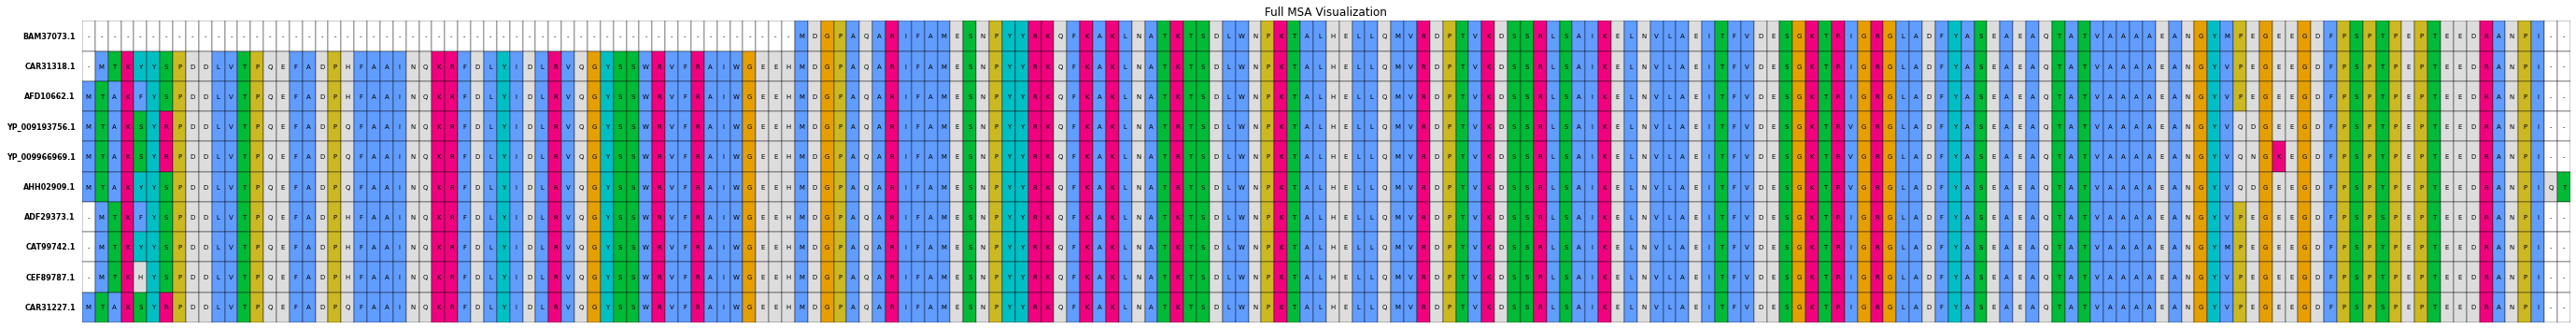

In [16]:
# Define residue color classes (ggmsa-like style)
residue_colors = {
    'G': '#E69F00',         # Orange
    'P': '#CCB822',         # Mustard
    'T': '#00BA38', 'S': '#00BA38',   # Green
    'Y': '#00BFC4',         # Teal
    'K': '#F0027F', 'R': '#F0027F',   # Red
    'L': '#619CFF', 'I': '#619CFF', 'V': '#619CFF', 'A': '#619CFF', 
    'W': '#619CFF', 'F': '#619CFF', 'C': '#619CFF', 'M': '#619CFF',
    '-': '#FFFFFF'          # White for gaps
}

default_color = '#DDDDDD'  # Light gray for unknown residues

alignment = AlignIO.read("aligned.aln", "clustal")
n_rows = len(alignment)
n_cols = alignment.get_alignment_length()

fig, ax = plt.subplots(figsize=(n_cols * 0.2, n_rows * 0.5))  # scale width & height based on content
ax.set_xlim(0, n_cols)
ax.set_ylim(0, n_rows)
ax.axis('off')

# Draw colored boxes with residue letters
for row_idx, record in enumerate(alignment):
    for col_idx, aa in enumerate(record.seq):
        aa = aa.upper()
        color = residue_colors.get(aa, default_color)
        rect = patches.Rectangle((col_idx, n_rows - row_idx - 1), 1, 1, facecolor=color, edgecolor='black', linewidth=0.4)
        ax.add_patch(rect)
        ax.text(col_idx + 0.5, n_rows - row_idx - 0.5, aa, ha='center', va='center', fontsize=7, color='black')

# Add sequence IDs
for row_idx, record in enumerate(alignment):
    ax.text(-0.5, n_rows - row_idx - 0.5, record.id, ha='right', va='center', fontsize=8, fontweight='bold')

plt.title("Full MSA Visualization", fontsize=12)
plt.tight_layout()
plt.show()


In [26]:
from Bio import AlignIO

color_map = {
    'E': '\033[37m', 'D': '\033[37m', 'A': '\033[37m', 'V': '\033[37m',
    'K': '\033[37m', 'M': '\033[37m', 'N': '\033[37m', 'F': '\033[37m',
    'T': '\033[37m', 'R': '\033[37m', 'Y': '\033[37m', 'Q': '\033[37m',
    '-': '\033[37m', 'S': '\033[37m', 'L': '\033[37m', 'I': '\033[37m',  # White (default fill group)

    'P': '\033[33m',                        # Mustard/Yellow
    'L': '\033[34m', 'I': '\033[34m', 'A': '\033[34m', 'W': '\033[34m',
    'V': '\033[34m', 'F': '\033[34m', 'C': '\033[34m', 'M': '\033[34m',  # Blue-violet
    'T': '\033[32m', 'S': '\033[32m',                                   # Green
    'Y': '\033[36m',                                                    # Cyan
    'G': '\033[91m',                                                    # Orange
    'K': '\033[31m', 'R': '\033[31m',                                   # Red
}
reset = '\033[0m'

alignment_path = "aligned.aln"
alignment = AlignIO.read(alignment_path, "clustal")
print("CLUSTAL O(1.2.4) multiple sequence alignment\n")

block_size = 60
alignment_length = alignment.get_alignment_length()

for block_start in range(0, alignment_length, block_size):
    block_end = min(block_start + block_size, alignment_length)
    print()
    for record in alignment:
        seq_block = record.seq[block_start:block_end]
        colored_seq = ''.join(color_map.get(res.upper(), '') + res + reset for res in seq_block)
        print(f"{record.id.ljust(15)} {colored_seq}")


CLUSTAL O(1.2.4) multiple sequence alignment


BAM37073.1      -------------------------------------------------------MDGPA
CAR31318.1      -MTKYYSPDDLVTPQEFADPHFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA
AFD10662.1      MTAKFYSPDDLVTPQEFADPHFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA
YP_009193756.1  MTAKSYRPDDLVTPQEFADPQFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA
YP_009966969.1  MTAKSYRPDDLVTPQEFADPQFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA
AHH02909.1      MTAKYYSPDDLVTPQEFADPQFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA
ADF29373.1      -MTKFYSPDDLVTPQEFADPHFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA
CAT99742.1      -MTKYYSPDDLVTPQEFADPHFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA
CEF89787.1      -MTKHYSPDDLVTPQEFADPHFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA
CAR31227.1      MTAKSYRPDDLVTPQEFADPQFAAINQKRFDLYIDLRVQGYSSWRVFRAIWGEEHMDGPA

BAM37073.1      QARIFAMESNPYYRKQFKAKLNATKTSDLWNPKTALHELLQMVRDPTVKDSSRLSAIKEL
CAR31318.1      QARIFAMESNPYYRKQFKAKLNATKTSDLWNPKTALHELLQMVRDPTVKDSSRLSAIKEL
AFD10662.1      QARIFAMESNPY